# HITS (Hubs and Authorities)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/08 12:41:16 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.17 instead (on interface eth0)
22/02/08 12:41:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/08 12:41:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/08 12:41:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



## Keep only 7 days

In [19]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|152|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|152|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|152|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import hour,dayofweek, count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|        114|       81|        7631984|      7631984|               5|       161|2021-06-03 07:34:29|154|   15|
|     631781|       81|        7631984|      7631984|               5|       161|2021-06-03 07:32:39|154|   15|
|     900130|      283|        7631984|      7631984|               5|       264|2021-06-03 13:04:24|154|   15|
|     203001|       81|        7631984|      7631984|               5|       161|2021-06-03 13:13:56|154|   15|
|     631349|       81|        7631984|      7631984|               5|       161|2021-06-03 13:26:40|154|   15|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

In [21]:
df_with_time_columns = df_cleaned.withColumn('time', (dayofweek(df.PASS_DAY_TIME)-1)*24 + hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'time')
df_with_time_columns.show(5)

+-----------+-------------+----+
|DEVICE_CODE|FINAL_CAR_KEY|time|
+-----------+-------------+----+
|        114|      7631984| 103|
|     631781|      7631984| 103|
|     900130|      7631984| 109|
|     203001|      7631984| 109|
|     631349|      7631984| 109|
+-----------+-------------+----+
only showing top 5 rows



In [22]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'time'
).count()
camera_daily_df.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     900265|  35| 1608|
|     631361|  89|  910|
|     900216|  55| 1758|
|  100700901|  62|   54|
|  100700845|   6|  886|
+-----------+----+-----+
only showing top 5 rows



In [23]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

+-----------+----+-----+------+
|DEVICE_CODE|time|count|camera|
+-----------+----+-----+------+
|     900265|  35| 1608| 241.0|
|     631361|  89|  910| 129.0|
|     900216|  55| 1758| 207.0|
|  100700901|  62|   54|  22.0|
|  100700845|   6|  886|  11.0|
+-----------+----+-----+------+
only showing top 5 rows



In [24]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (int(x['camera']), int(x['time']), x['count']) ))

In [25]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
print(u)
print(s)
print(v)

22/02/08 13:13:33 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/02/08 13:13:33 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK


[188271.66600858152,31726.72347411335,25917.749195161658,21968.311152889397,17315.48081317604,12812.607827985737,11410.508727943672,10785.918588789793,10121.951375287717,9251.080116445459]
DenseMatrix([[-0.02181479, -0.03166442, -0.01210924, ..., -0.04270199,
               0.00184222, -0.00566491],
             [-0.01454072, -0.02258541, -0.00869482, ..., -0.03088935,
              -0.00571353, -0.00974713],
             [-0.00793662, -0.01203552, -0.00470303, ..., -0.01798502,
              -0.00365916, -0.00681527],
             ...,
             [-0.08776691, -0.06104443, -0.07625721, ..., -0.07529783,
              -0.0101488 ,  0.07204838],
             [-0.04132909, -0.04295587, -0.02342279, ..., -0.0502602 ,
              -0.01153339,  0.00519515],
             [-0.02994968, -0.03864455, -0.01633105, ..., -0.04683206,
              -0.01384041,  0.00087887]])


22/02/08 13:13:48 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [26]:

import numpy as np
print(type(u.rows.take(1)[0]))
hubs = u.rows.map(lambda x: x.toArray()[0] * -1).collect()
# times = v.rows.map(lambda x: x.toArray()[0] * -1).collect()
times = v.toArray()
# print(times)
times = times[:,0] * -1
print(times)
print('number of cameras: ', len(hubs))
print('number of times: ', len(times))

# print('camera ratings: ', u[:,0])
print('camera ratings: ', hubs)
print('time ratings: ', times)
# print('time ratings: ', v[:,0])

<class 'pyspark.mllib.linalg.DenseVector'>
[0.02181479 0.01454072 0.00793662 0.00851296 0.00693132 0.01020027
 0.02402674 0.03472469 0.04307125 0.05354024 0.07011996 0.08389912
 0.08828023 0.0827309  0.07438185 0.06850134 0.0776734  0.09364762
 0.10489966 0.11317219 0.10632912 0.09308412 0.04377043 0.03207097
 0.02104613 0.01301153 0.00719644 0.00745724 0.00836839 0.0274353
 0.0887322  0.11821339 0.1079991  0.09495844 0.09494098 0.09045897
 0.09061063 0.08916523 0.0975633  0.10176703 0.11784781 0.12134168
 0.11806536 0.11859147 0.10962182 0.0832641  0.03482951 0.02823373
 0.01707337 0.00965662 0.00535823 0.00551635 0.00698724 0.02422431
 0.08161567 0.11448726 0.10452615 0.09061134 0.09291748 0.09651075
 0.09354661 0.08772409 0.09585697 0.09819274 0.11807692 0.11873505
 0.11299549 0.11462013 0.10455745 0.08774597 0.0424666  0.02920635
 0.01839301 0.01043588 0.00571154 0.0057729  0.00732415 0.02548413
 0.08851679 0.12266528 0.1120539  0.10312267 0.10191877 0.09816262
 0.09413808 0.090237

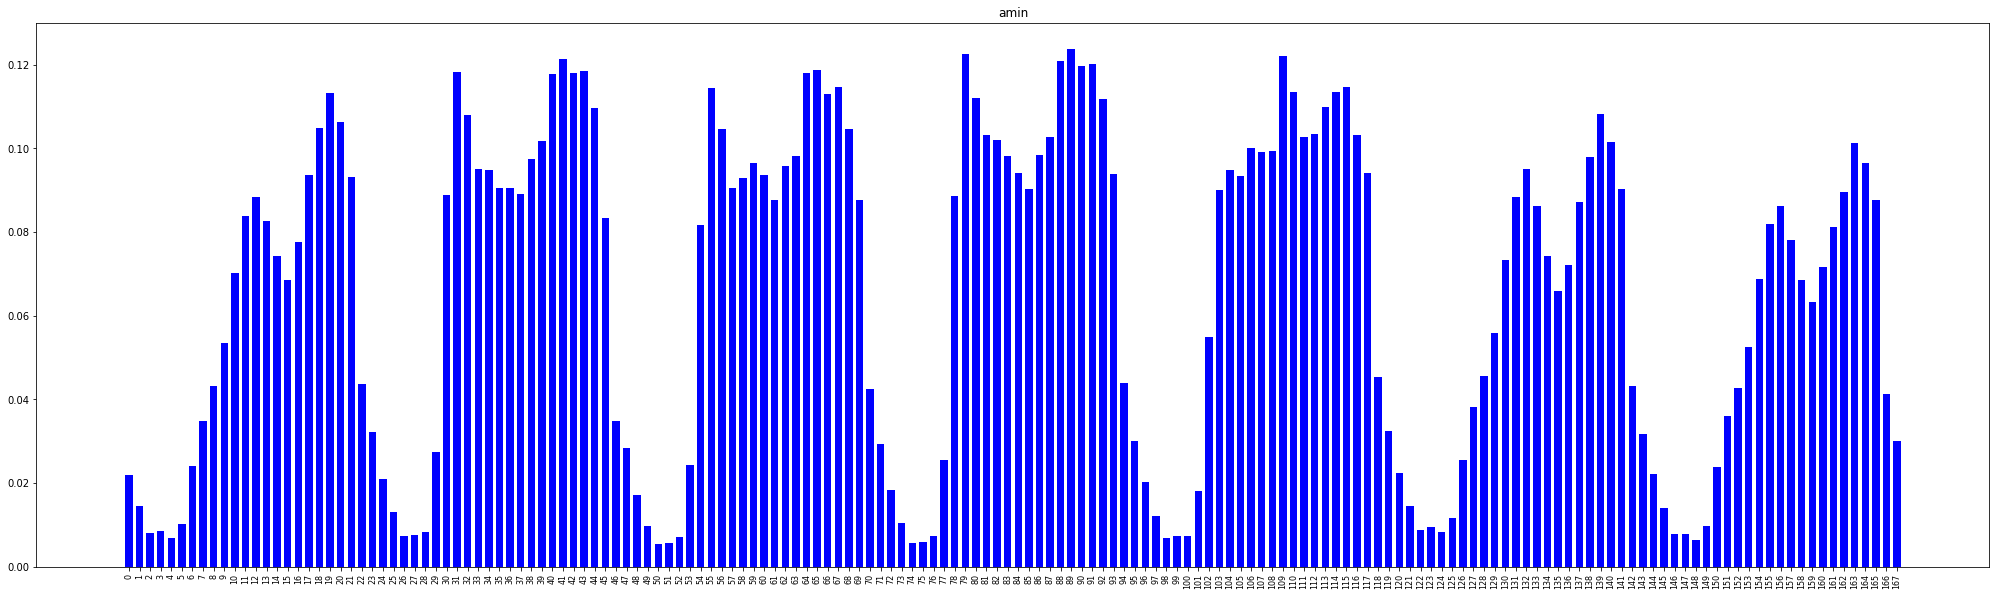

In [31]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (35, 10))
# print(len(lable_list))
# print(len(topics[:,topic]))
label_list = list(map(lambda x: str(x), range(24*7)))
plt.bar(label_list, times, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('amin')
plt.show()

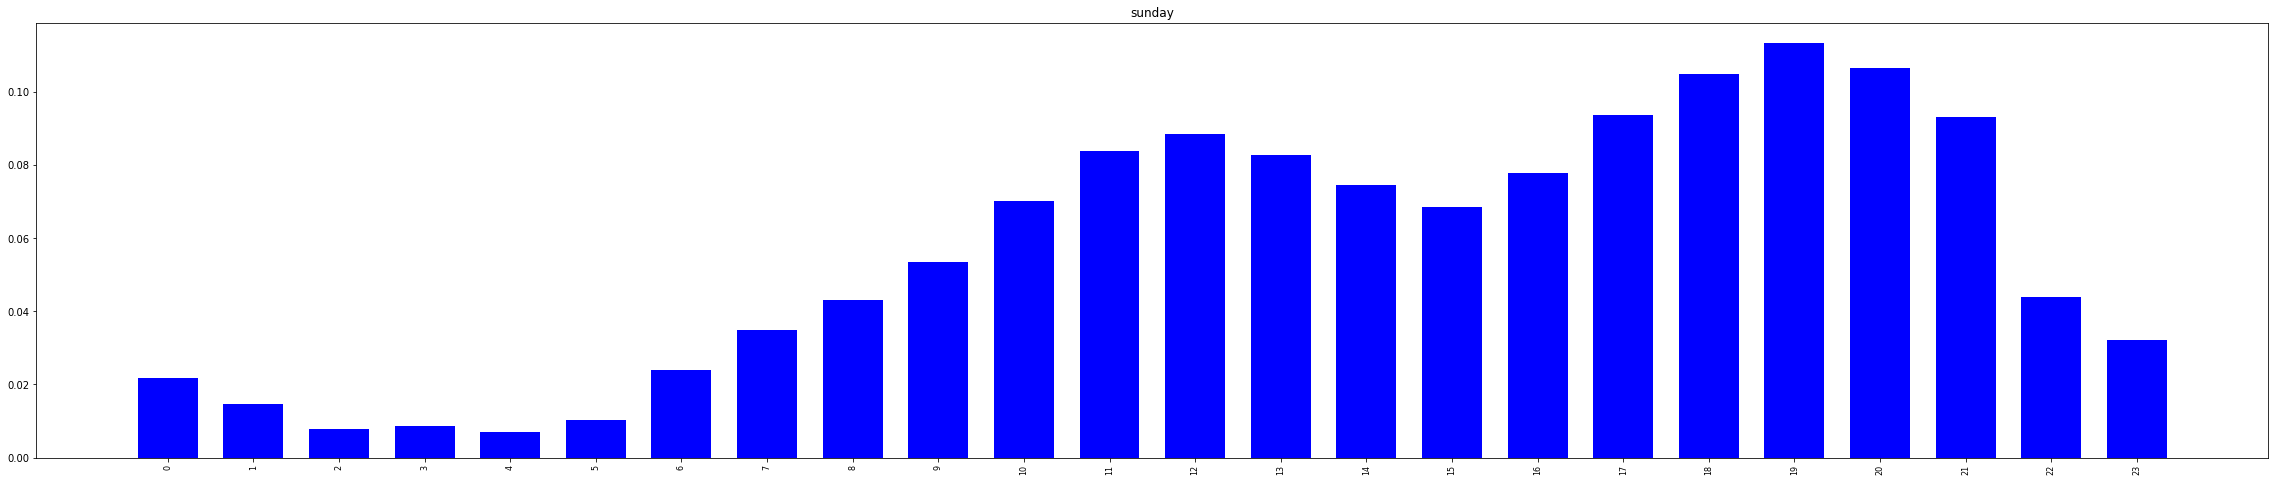

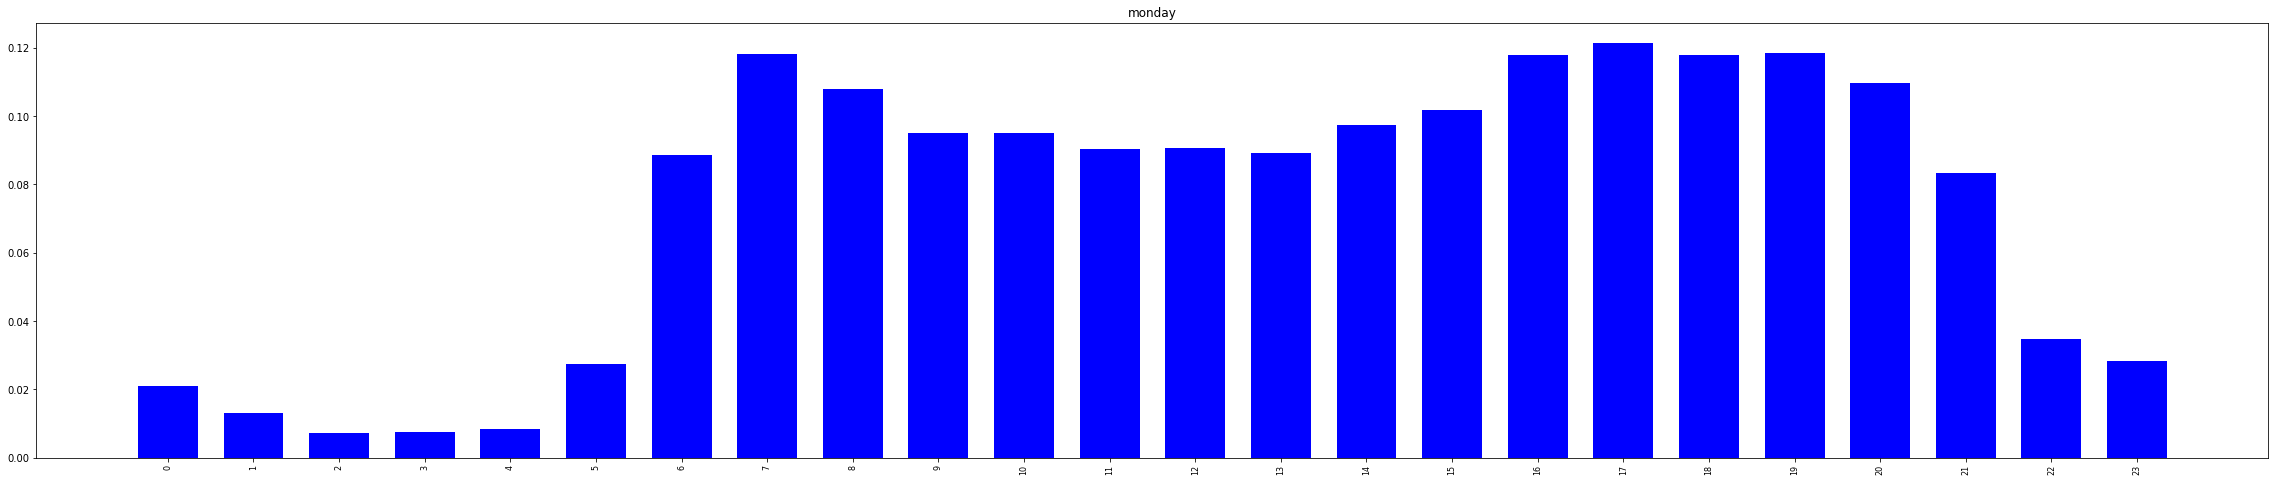

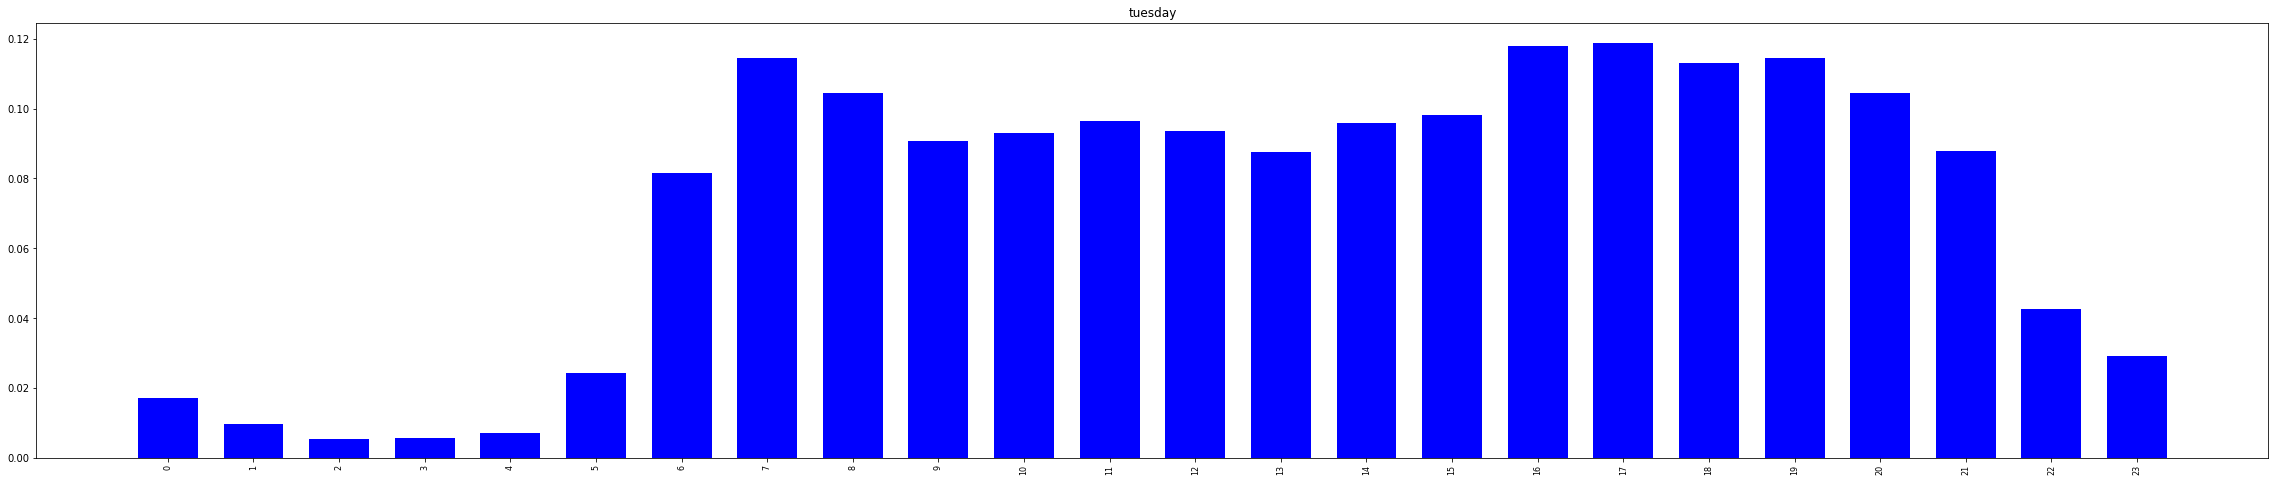

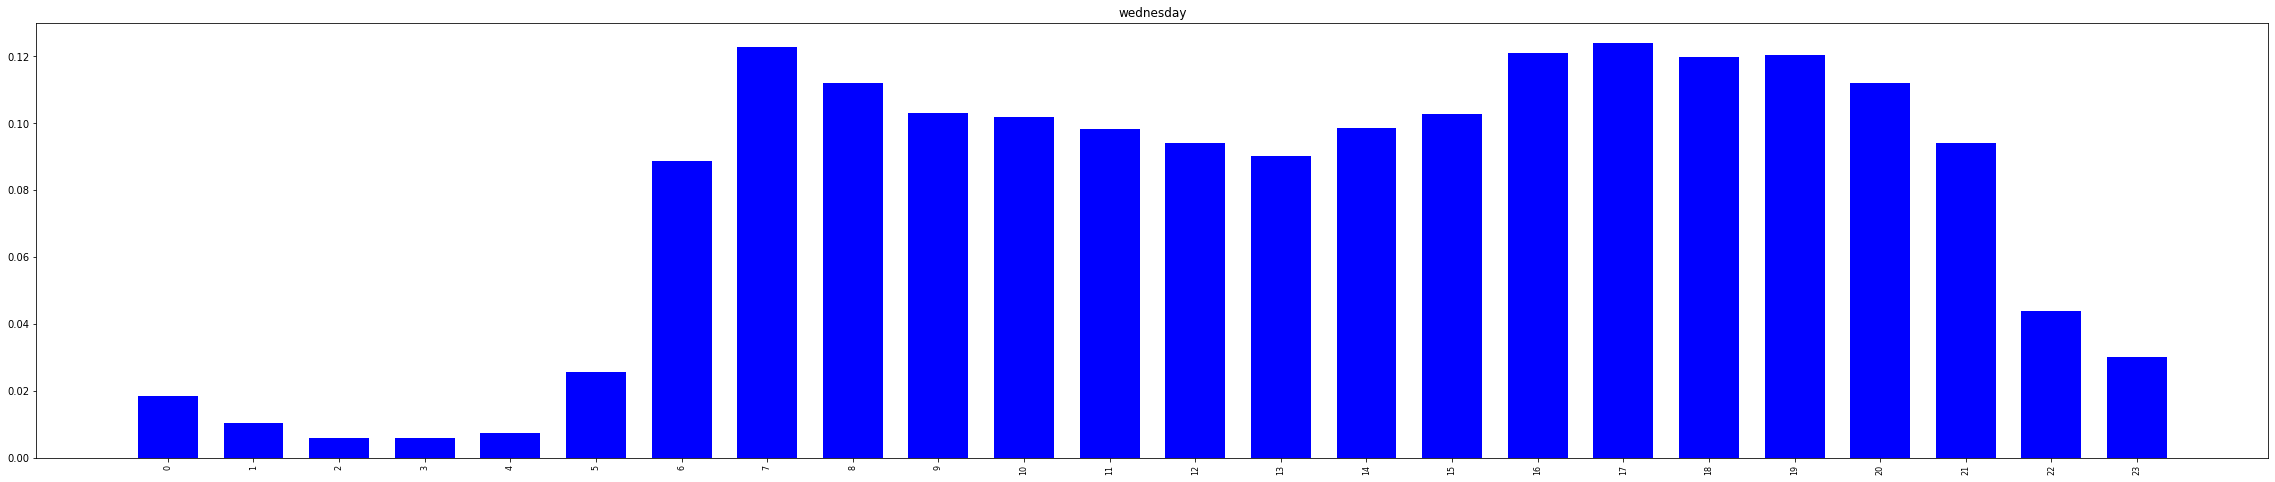

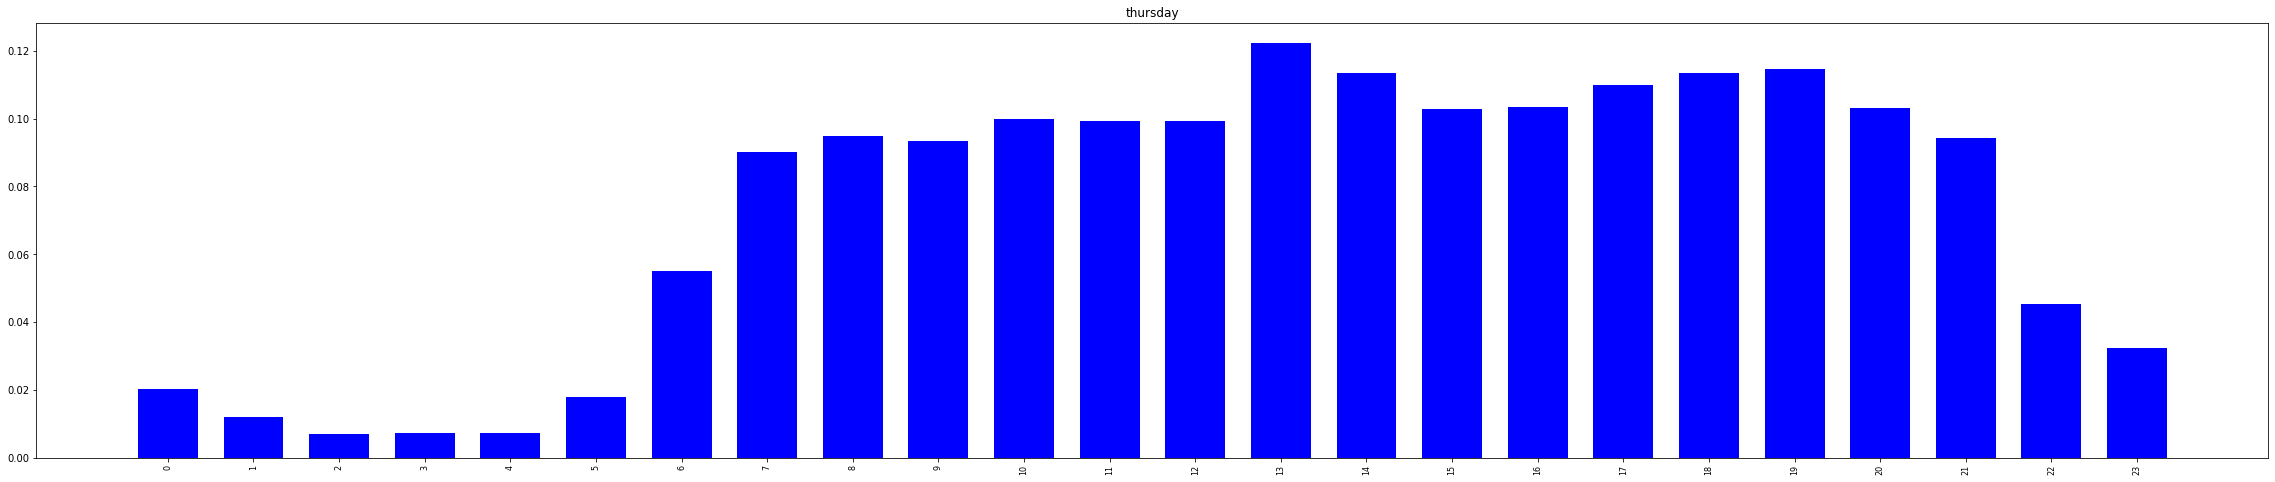

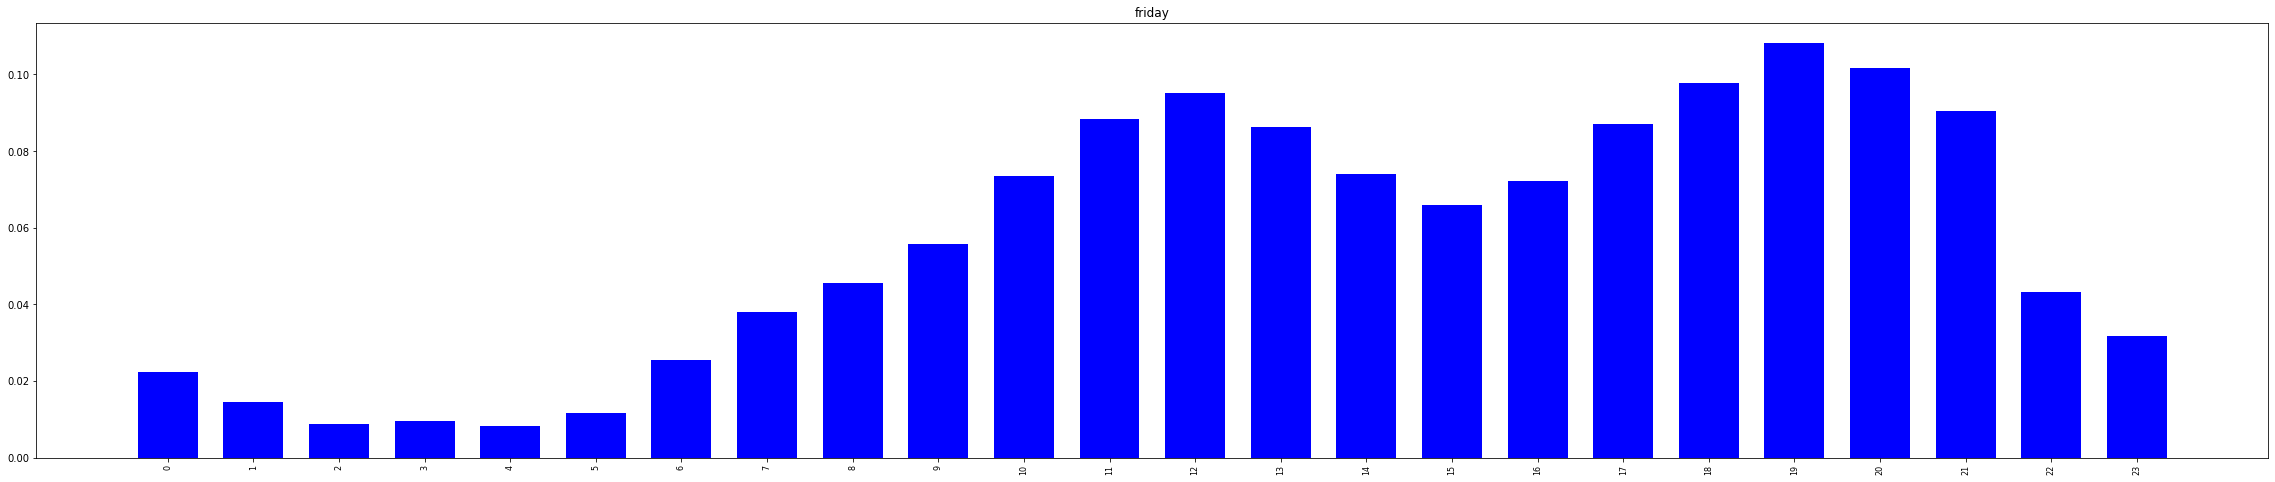

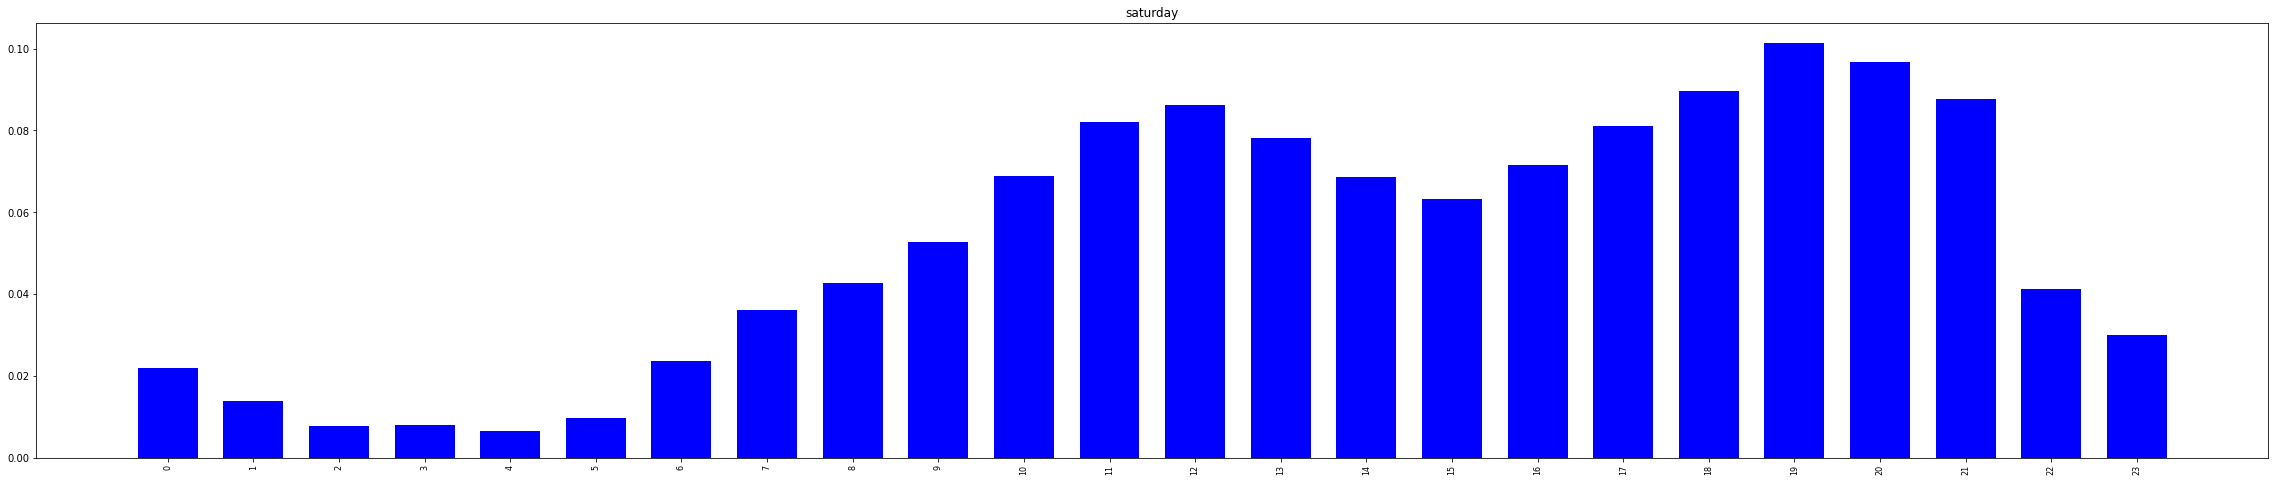

In [32]:
from matplotlib import pyplot as plt

weekdays = [
    'sunday',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    ]
for day_index, day in enumerate(weekdays):
    fig = plt.figure(figsize = (40, 8))
    labels = list(map(lambda x: str(x), range(24)))
    chart = times[day_index*24: (day_index+1)*24]
    plt.bar(labels, chart, color ='blue', width = 0.7)
    plt.xticks(rotation='vertical',fontsize=8)
    plt.title(day)
    plt.show()